# SPRIGS 2025 - Gaussian Processes in the Time Domain

Presented by Courtney Crawford (courtney.crawford@sydney.edu.au)

## Prerequisites
### Imports

For this notebook to work, you will require the following packages to be installed on whatever Python environment you choose to run this tutorial in.

* numpy
* matplotlib
* pandas
* astropy
* ipywidgets
* pickle (default with python)
* celerite2 [docs_link_here](https://celerite2.readthedocs.io/en/latest/)
* emcee [docs_link_here](https://emcee.readthedocs.io/en/stable/)
* corner [docs_link_here](https://corner.readthedocs.io/en/latest/)

* lightkurve (optional)

In the github repo is a .yml file that you can use to create your environment if you're using conda. The terminal command is
```
conda env create -f gpr_tut_env.yml
```

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.timeseries import LombScargle
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel

import celerite2
from celerite2 import terms, GaussianProcess
import emcee
import corner
from scipy.optimize import minimize

import pickle

In [ ]:
# optional imports for generating datasets
# import lightkurve as lk
# from astropy.stats import sigma_clip

In [ ]:
## replace with the path to your copy of this tutorial and the repository to run it
tutorial_dir = '/Users/aion/Desktop/SPRIGS_gpr_tutorial/'

In [ ]:
# plot style commands
# plt.style.use('court.mplstyle')

### Some Convenience Functions

In [ ]:
import psd_functions as psd
def boxsmooth(x,width=100):
    return convolve(x,Box1DKernel(width))

### A note about this notebook

Throughout this notebook, for speed reasons and to keep the number of required Python packages low, I've provided you with a number of files (in the github repo where you downloaded this) that contain pre-computed light curves, regressions, etc. In all cases, I will include a commented out cell that explains how that file was generated, as well as what packages would be required to generate it. These will come chronologically as the files are needed. If you are running this on your own later or adapting it to your own needs, feel free to use the codes in those cells if you like.

### Finally, some further reading

This notebook contains an amalgamation of things that I've found helpful while learning how to use GPs, as well as some examples of my own work. Below is a list of resources that I have found particularly useful, or directly pulled from in some cases.

* Suzanne Aigrain and Dan Foreman-Mackey (2023) - Gaussian Process Regression for Astronomical Time Series - review article [adslink](https://ui.adsabs.harvard.edu/abs/2023ARA%26A..61..329A/abstract)
* Foreman-Mackey et al. (2017) - Fast and Scalable Gaussian Process Modeling with Applications to Astronomical Time Series - Source paper for the SHO Kernel and celerite on the whole [adslink](https://ui.adsabs.harvard.edu/abs/2017AJ....154..220F/abstract)
* Niamh K. O'Sullivan and Suzanne Aigrain (2024) - Modelling stochastic and quasi-periodic behaviour in stellar time-series: Gaussian process regression versus power-spectrum fitting - article discussing the difference between GP analysis and Fourier analysis of time series data [adslink](https://ui.adsabs.harvard.edu/abs/2024MNRAS.531.4181O/abstract)
* A Visual Exploration of Gaussian Processes [htmllink](https://distill.pub/2019/visual-exploration-gaussian-processes/)


# Part 1: The Not Gaussian Process Stuff

## A statistics primer on least squares regression

How does a typical (least-squares) regression work? 

Let's imagine a two-dimensional data set that's well modelled by a line, with some regular uncertainty in the measurements.

We need to start with a few assumptions for our data:
- data points are indepedent
- uncertainties are Gaussian-distributed

In [ ]:
## define a line function
def linear_poly(x,m,b):
    return m*x + b

## create some synthetic data
x_true = np.arange(0,100)
m_true = 0.1
b_true = 1.4
sigma = 1.0
y_true = linear_poly(x_true,m_true,b_true) + np.random.normal(0, sigma, size=len(x_true))


## plot the data for visualization
plt.scatter(x_true,y_true,s=5,label='simulated data w uncertainties')
plt.errorbar(x_true,y_true,yerr=sigma,marker='None',linestyle='None',ecolor='grey',linewidth=0.5,zorder=0)
# plt.plot(linear_poly(x_true,m_true,b_true),color='tab:red',linestyle='--',label='ground truth')

plt.legend()
plt.xlabel('X (inputs)')
plt.ylabel('Y (measurements)')
plt.show()

Now, if we want to figure out what the best slope and intercept (m and b) are for this dataset, we can use a least-squares regression to do so.
    

Formally, we assume that data points can be interpreted like this:  
$$ y_{\rm measured} = y_{\rm true}(x, \theta) + \epsilon $$  
where $\epsilon$ is the measurement uncertainty and $\theta$ are the parameters that you will be fitting for.

If the distribution of $\epsilon$ follows a Gaussian/Normal distribution, then we can define a quantity called $\chi^2$ (consult a statistics textbook if you're not convinced)  
$$ \chi^2 = \sum_{i = 1}^{N}\frac{(y_{\rm measured,i} - y_{\rm predicted,i})^2}{\sigma_i^2} $$   
For our "best fit" we want this quantity to be as small as possible, or in other words we want this to be minimized. This intuitively means that we want all of the points predicted by the model to be as close as possible to the real values, but we weight by our measurement uncertainty.

In [ ]:
## Lets visualize this real quick by plotting three different fits

## define chi-squared function
def chi_squared(x,y_measured,m_guess,b_guess,sigma):
    y_predicted = linear_poly(x,m_guess,b_guess)
    chi_sq_i = (y_measured-y_predicted)**2/sigma**2
    return np.sum(chi_sq_i)


f,ax = plt.subplots(1,3,figsize=(15,4))
## Fit one
ax[0].scatter(x_true,y_true,s=5,label='simulated data w uncertainties')
ax[0].errorbar(x_true,y_true,yerr=sigma,marker='None',linestyle='None',ecolor='grey',linewidth=0.5,zorder=0)
ax[0].plot(linear_poly(x_true,0.5,-10),color='tab:red',linestyle='--',label='fit 1')
ax[0].annotate(r'$\chi^2$:'+str(np.round(chi_squared(x_true,y_true,0.5,-10,sigma),2)),
            xy=(0.5,0.1),xycoords='axes fraction',fontsize=20)

ax[0].legend()
ax[0].set_xlabel('X (inputs)')
ax[0].set_ylabel('Y (measurements)')
# plt.show()

## Fit two
ax[1].scatter(x_true,y_true,s=5,label='simulated data w uncertainties')
ax[1].errorbar(x_true,y_true,yerr=sigma,marker='None',linestyle='None',ecolor='grey',linewidth=0.5,zorder=0)
ax[1].plot(linear_poly(x_true,0.2,-1.2),color='tab:red',linestyle='--',label='fit 2')
ax[1].annotate(r'$\chi^2$:'+str(np.round(chi_squared(x_true,y_true,0.2,-1.2,sigma),2)),
            xy=(0.5,0.1),xycoords='axes fraction',fontsize=20)

ax[1].legend()
ax[1].set_xlabel('X (inputs)')
# ax[1].set_ylabel('Y (measurements)')
# plt.show()

## Fit three
ax[2].scatter(x_true,y_true,s=5,label='simulated data w uncertainties')
ax[2].errorbar(x_true,y_true,yerr=sigma,marker='None',linestyle='None',ecolor='grey',linewidth=0.5,zorder=0)
ax[2].plot(linear_poly(x_true,-0.3,5.3),color='tab:red',linestyle='--',label='fit 3')
ax[2].annotate(r'$\chi^2$:'+str(np.round(chi_squared(x_true,y_true,-0.3,5.3,sigma),2)),
            xy=(0.5,0.1),xycoords='axes fraction',fontsize=20)

ax[2].legend(loc='upper left')
ax[2].set_xlabel('X (inputs)')
# plt.ylabel('Y (measurements)')
plt.show()


Now you can imagine that varying m and b (in other words, $\theta$) sweeps out a distribution of $\chi^2$ values

In [ ]:
## we can plot that distribution
# Define 1D coordinate arrays
# recall that
# m_true = 0.1
# b_true = 1.4
m_testing = np.linspace(m_true-1,m_true+1,50)
b_testing = np.linspace(b_true-10,b_true+10,50)

# Create a meshgrid
m_grid, b_grid = np.meshgrid(m_testing, b_testing)

In [ ]:
# Compute chi-squared values on the grid
chi_sq_grid = np.zeros_like(m_grid)

for i in range(m_grid.shape[0]):
    for j in range(m_grid.shape[1]):
        m = m_grid[i, j]
        b = b_grid[i, j]
        chi_sq_grid[i, j] = chi_squared(x_true, y_true, m, b, sigma)

In [ ]:
# Plot with imshow
plt.figure(figsize=(8, 6))
im = plt.imshow(np.log10(chi_sq_grid), origin='lower',
                extent=[m_testing[0], m_testing[-1], b_testing[0], b_testing[-1]],
                aspect='auto', cmap='viridis')
plt.colorbar(im, label=r'log10($\chi^2$)')
plt.xlabel('Slope (m)')
plt.ylabel('Intercept (b)')
plt.title(r'$\chi^2$ Grid for Linear Fit')
plt.scatter(m_true, b_true, color='red', label='True Params', marker='x')
plt.legend()
plt.show()

This $\chi^2$ function is in a family of functions known as "Likelihood functions." Now technically, $\chi^2$ is actually more closely related to the **negative log likelihood**, which wants to be minimized, rather than maximized, but in practice one can think of these optimization problems in very similar ways.

To be a bit more formal (this will be useful later) this $\chi^2$ function comes originally from the likelihood function for independent data with Gaussian-distributed errors:   
$$ \mathcal{L}(\theta) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi \sigma_i^2}} \exp\left( -\frac{(y_i - f(x_i; \theta))^2}{2\sigma_i^2} \right) $$
We can take the logarithm of this:  
$$ \ln \mathcal{L}(\theta) = -\frac{1}{2} \sum_{i=1}^n \left[ \ln(2\pi \sigma_i^2) + \frac{(y_i - f(x_i; \theta))^2}{\sigma_i^2} \right] $$  
Which can also be written as:  
$$ \ln \mathcal{L}(\theta) = \text{const} - \frac{1}{2} \chi^2(\theta) $$
Thus, we drop some constants and end up with the $\chi^2$ function:  
$$ \chi^2(\theta) = \sum_{i=1}^n \frac{(y_i - f(x_i; \theta))^2}{\sigma_i^2} $$  

**And thus, least-squares regression is essentially a problem of minimizing this function (maximizing the likelihood)**

## A discussion about covariances (aka correlation, aka a kernel function)

So, let's take a moment to examine one of our assumptions for our data, which is that the individual data points are independent. Another way to say this is that there is no covariances in our data.

Now, having "no covariance" is also, somewhat humorously, a definition of a covariance matrix, but it's a purely diagonal covariance matrix.

To be explicit, when we say our data points are independent (no covariance), we are saying that the individual points and their uncertainties do not depend on the other points. In mathematical terms, we can describe the covariance matrix of our data using a function of this form:

$$ K_{ij} = \sigma_{i}^2\delta_{ij} = \begin{pmatrix}
\sigma_{11} & 0 & 0 & \cdots & 0 \\
0 & \sigma_{22} & 0 & \cdots & 0 \\
0 & 0 & \sigma_{33} & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & \sigma_{nn}
\end{pmatrix}$$

Where $\delta_{ij}$ is the Kronecker delta function.

In [ ]:
## A small visualization of the covariance matrix
# Create a meshgrid
i_grid, j_grid = np.meshgrid(np.arange(0,len(x_true)), np.arange(0,len(x_true)))

# fill in the elements of the matrix
ind_cov_mat = np.zeros_like(i_grid)
for i in range(i_grid.shape[0]):
    for j in range(i_grid.shape[1]):
        if i == j:
            ind_cov_mat[i, j] = sigma**2
        else:
            ind_cov_mat[i, j] = 0

In [ ]:
# Plot with imshow
plt.figure(figsize=(8, 6))
im = plt.imshow(ind_cov_mat, origin='upper',
                extent=[i_grid[0][0], i_grid[-1][-1], j_grid[-1][-1], j_grid[0][0]],
                aspect='auto', cmap='viridis')
plt.colorbar(im, label='covariance')
plt.xlabel('index (of x)')
plt.ylabel('index (of x)')
plt.title(r'Independent Covariance Matrix')
plt.show()

Next, lets for a moment look at a qualitative representation of data with this type of covariance matrix

In [ ]:
## independent data points (no covariance)
## create some synthetic data
x_true = np.arange(0,100)
sigma = 1.0
y_independent = np.random.normal(0, sigma, size=len(x_true))


## plot the data for visualization
plt.plot(x_true,y_independent,marker='.',label='simulated data')
plt.axhline(sigma,color='k',linestyle='--',label=r'1 $\sigma$')
plt.axhline(-sigma,color='k',linestyle='--')

plt.legend()
plt.ylim(-4*sigma,4*sigma)
plt.xlabel('X (inputs)')
plt.ylabel('Y (measurements)')
plt.show()

Looks typical!

Now lets consider what happens when our data does have some covariances. Lets consider a very simple case of a squared exponential covariance:
$$ k(\tau, \theta) = \alpha^2 \exp\left(\frac{-\tau^2}{2\ell^2}\right) $$
We have defined an interval $\tau = |x_i-x_j|$, $\alpha$ is the variance along the diagonal, and $\ell$ is a length scale describing how many points away a data point is correlated to.

In [ ]:
## A small visualization of the covariance matrix
# Create a meshgrid
# i_grid, j_grid = np.meshgrid(np.arange(0,len(x_true)), np.arange(0,len(x_true)))


sqexp_cov_mat = np.zeros_like(i_grid)
alpha = 2
ell = 5
for i in range(i_grid.shape[0]):
    for j in range(i_grid.shape[1]):
        tau = np.abs(x_true[i]-x_true[j])
        sqexp_cov_mat[i, j] = alpha**2*np.exp(-tau**2/(2*ell**2))

In [ ]:
# Plot with imshow
plt.figure(figsize=(8, 6))
im = plt.imshow(sqexp_cov_mat, origin='upper',
                extent=[i_grid[0][0], i_grid[-1][-1], j_grid[-1][-1], j_grid[0][0]],
                aspect='auto', cmap='viridis')
plt.colorbar(im, label='covariance')
plt.xlabel('index (of x)')
plt.ylabel('index (of x)')
plt.title(r'Squared-Exponential Covariance Matrix')
plt.show()

For funsies, lets make a little interactive plot to show what changing these parameters does to the covariance matrix.

If this doesn't work on your computer, feel free to skip it and look at the link I added below (where I took this idea from)

In [ ]:
from ipywidgets import interact, IntSlider, FloatSlider, fixed

In [ ]:
def sqexp_covariance_flexible(x, alpha, ell, sigma_diag=0):
    # sigma_diag is optional but helpful for regularization
    # it just adds a little bit of extra variance on the diagonal, like a white noise term
    i_grid, j_grid = np.meshgrid(np.arange(0,len(x)), np.arange(0,len(x)))
    cov_mat = np.zeros_like(i_grid)
    for i in range(i_grid.shape[0]):
        for j in range(i_grid.shape[1]):
            if i == j:
                cov_mat[i, j] = alpha**2 + sigma_diag**2
            else:
                tau = np.abs(x[i]-x[j])
                cov_mat[i, j] = alpha**2*np.exp(-tau**2/(2*ell**2))
    return cov_mat
            
def sqexp_wrapper(x, alpha, ell, fixed_colorbar_lims=True):
    sqexp_cov_mat = sqexp_covariance_flexible(x, alpha, ell)
    # Plot with imshow
    plt.figure(figsize=(8, 6))
    im = plt.imshow(sqexp_cov_mat, origin='upper',
                    extent=[x[0], x[-1], x[-1], x[0]],
                    aspect='auto', cmap='viridis')
    plt.colorbar(im, label='covariance')
    if fixed_colorbar_lims:
        plt.clim(0,50)
    plt.xlabel('index (of x)')
    plt.ylabel('index (of x)')
    plt.title(r'Squared-Exponential Covariance Matrix')
    plt.show()

In [ ]:
## if this cell doesn't work, I'm sorry, idk how to fix it. It works on my laptop but not my desktop
interact(sqexp_wrapper,x=fixed(x_true),
         alpha=FloatSlider(min=0,max=10,step=0.2,value=5),
         ell=FloatSlider(min=0.001,max=10,step=0.2,value=5),
        fixed_colorbar_lims=True)

Now lets visualize what data sampled from this kind of covariance matrix looks like

In [ ]:
# Define a mean vector (assuming zero mean for simplicity)
mean_vec = np.zeros(len(x_true))
# Sample from the multivariate normal distribution
alpha = 20
ell = 5
y_sqexp = np.random.multivariate_normal(mean_vec, sqexp_covariance_flexible(x_true,alpha=alpha,ell=ell,sigma_diag=3))
### if you get a warning RuntimeWarning: covariance is not symmetric positive-semidefinite, increase sigma_diag ###


## plot the data for visualization
plt.plot(x_true,y_sqexp,marker='.',label='simulated data')
plt.axhline(alpha,color='k',linestyle='--',label=r'alpha')
plt.axhline(-alpha,color='k',linestyle='--')

plt.legend()
plt.xlabel('X (inputs)')
plt.ylabel('Y (measurements)')
plt.show()

If you want to visualize a few more covariance matrices and what data sampled from them looks like, I recommend this website:  

A Visual Exploration of Gaussian Processes [htmllink](https://distill.pub/2019/visual-exploration-gaussian-processes/)

For even more kernel functions, here is Table 1 from Aigrain & Mackey's review paper

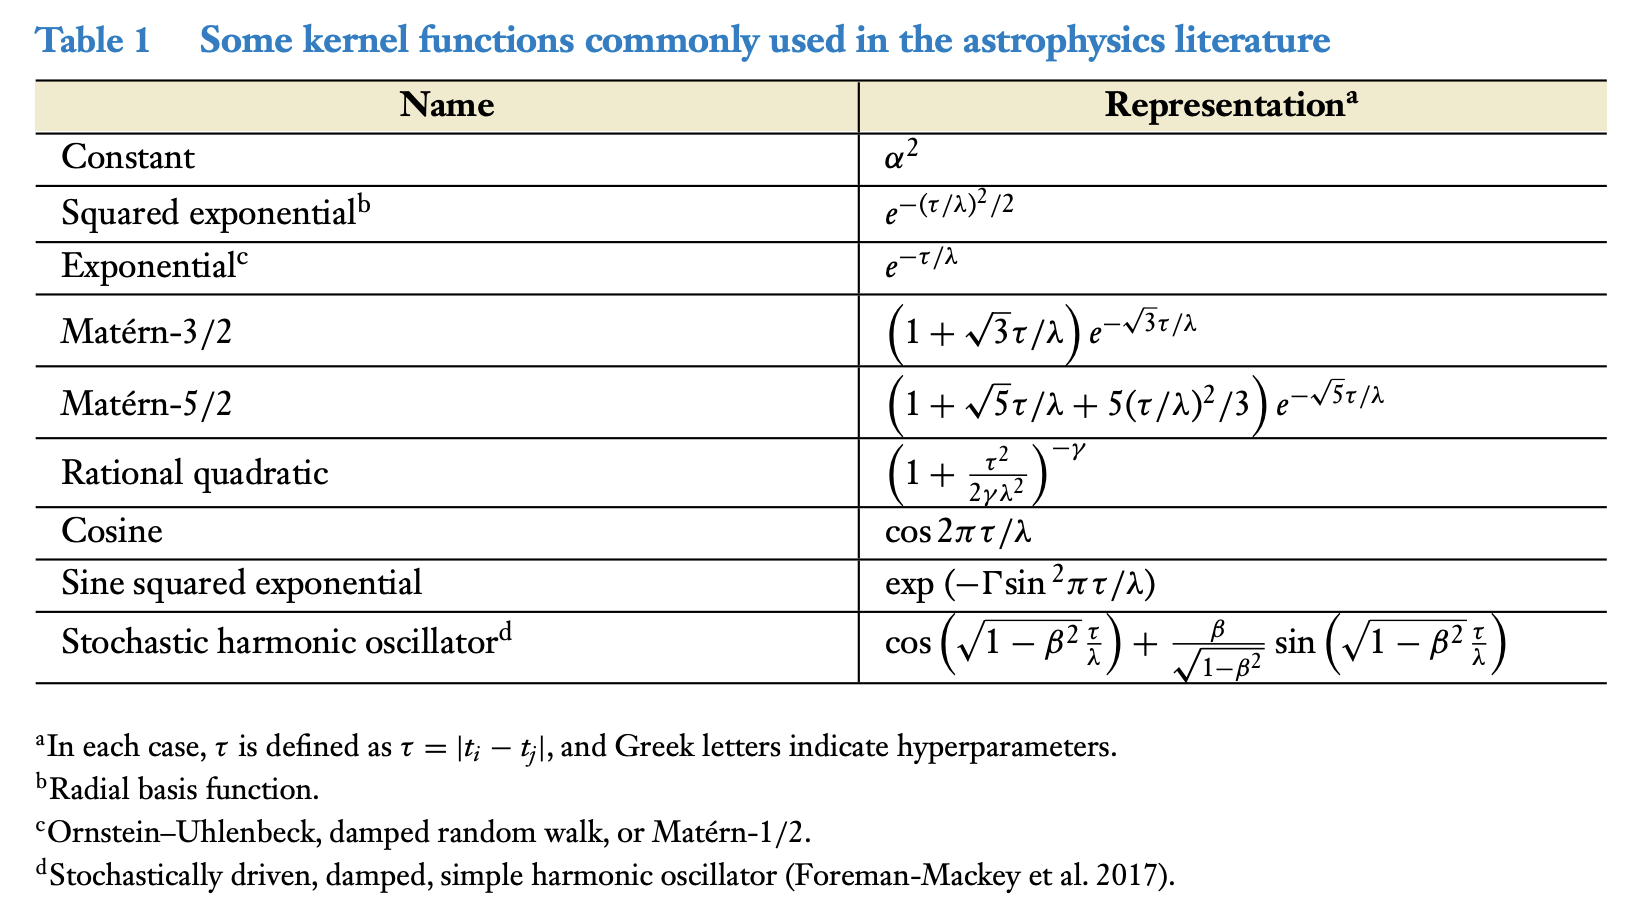

# Part 2: Astronomical Time Series

## Typical signals (periodic, transits, rotation, granulation) (and in fourier space)

As we know, periodic signals have known shapes in the Fourier Domain, as visualized below

In [ ]:
## normal sine wave
# build an arbitrary time grid
t = np.linspace(0, 50, 2000)
A = 4
phase = 0.2
period = 15
sine = A*np.sin(2*np.pi*(1/period)*t+phase)


## fourier transform this
freq,amp = psd.calc_lomb_scargle(t,sine,oversample=10,return_type='cd')

fig, ax = plt.subplots(1,2,figsize=(15,6))

ax[0].scatter(t,sine,s=1)
ax[0].axhline(A,color='tab:red',linestyle='--',label='amplitude')
ax[0].axvspan((phase*period),(phase*period)+period,color='grey',alpha=0.2,label='period')
ax[0].set_ylabel('signal')
ax[0].set_xlabel('time (days)')
ax[0].set_ylim(-5,5)
ax[0].set_title('Signal (sine wave)',fontsize=25)
# plt.show()


ax[1].plot(freq,amp)
ax[1].axhline(A,color='tab:red',linestyle='--',label='amplitude')
ax[1].axvline(1/period,color='grey',linestyle='--',label='1/period')
ax[1].set_xlabel('frequency (c/d)')
ax[1].set_ylabel('amplitude of sine wave (same units as signal)')
ax[1].set_xlim(0,1)
ax[1].set_ylim(0,5)
ax[1].set_title('(Discrete) Fourier Transform',fontsize=25)
plt.show()

In [ ]:
## Multiple sine waves
# build an arbitrary time grid
t = np.linspace(0, 50, 2000)
A = 4*np.abs(np.random.randn(3))
phase = 0.2*np.abs(np.random.randn(3))
period = 15*np.abs(np.random.randn(3))
sine = (A[0]*np.sin(2*np.pi*(1/period[0])*t+phase[0])+
        A[1]*np.sin(2*np.pi*(1/period[1])*t+phase[1])+
        A[2]*np.sin(2*np.pi*(1/period[2])*t+phase[2]))


## fourier transform this
freq,amp = psd.calc_lomb_scargle(t,sine,return_type='cd')

fig, ax = plt.subplots(1,2,figsize=(15,6))

ax[0].scatter(t,sine,s=1)
for i in range(0,len(A)):
    ax[0].axhline(A[i],color='tab:red',linestyle='--',label='amplitude')
    ax[0].axvspan((phase[i]*period[i]),(phase[i]*period[i])+period[i],color='grey',alpha=0.2,label='period')
ax[0].set_ylabel('signal')
ax[0].set_xlabel('time (days)')
ax[0].set_title('Signal (3 sine waves)',fontsize=25)

ax[1].plot(freq,amp)
for i in range(0,len(A)):
    ax[1].axhline(A[i],color='tab:red',linestyle='--',label='amplitude')
    ax[1].axvline(1/period[i],color='grey',linestyle='--',label='1/period')
ax[1].set_xlabel('frequency (c/d)')
ax[1].set_ylabel('amplitude of sine wave (same units as signal)')
ax[1].set_xlim(0,1)
ax[1].set_title('(Discrete) Fourier Transform',fontsize=25)
plt.show()

And in astronomy, especially in asteroseismolgy, we often work somewhat exclusively in the Fourier Domain. Some physical processes that we work with often have very well understood shapes in Fourier Space.

For example, below is a figure from from [J. Zhou 2024](https://ui.adsabs.harvard.edu/abs/2024ApJS..271...17Z/abstract) showcasing a Fourier fit to a red giant oscillator using three Lorentzian terms to model the background due to granulation and one Gaussian term to fit the shape of the oscillations

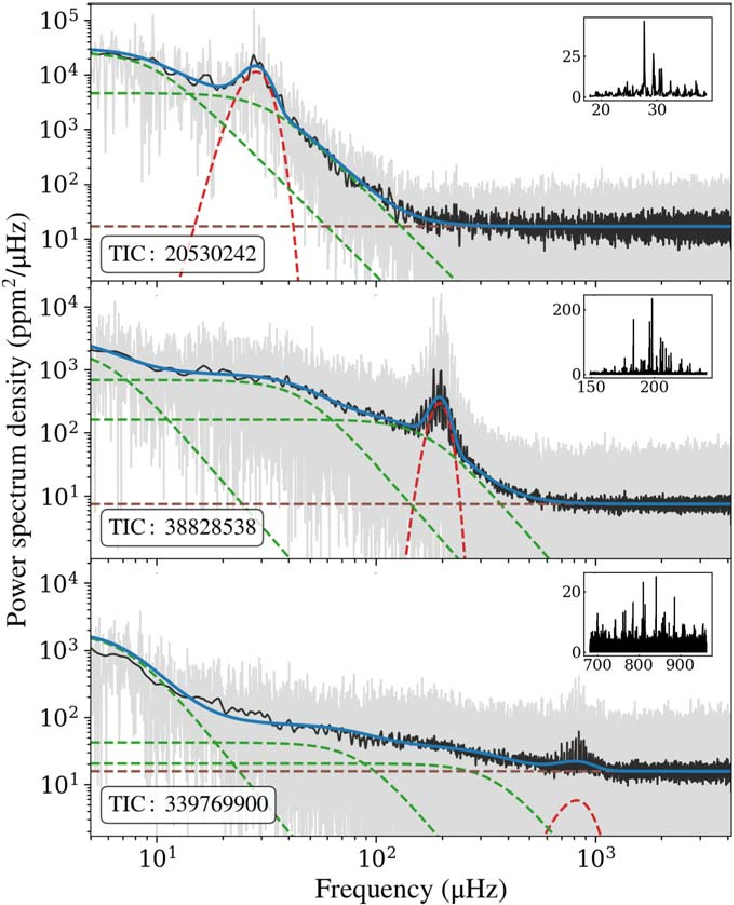

For some stars, the full model in power space can get quite complicated. This figure comes from O'Sullivan & Aigrain 2024 (link at top of notebook).

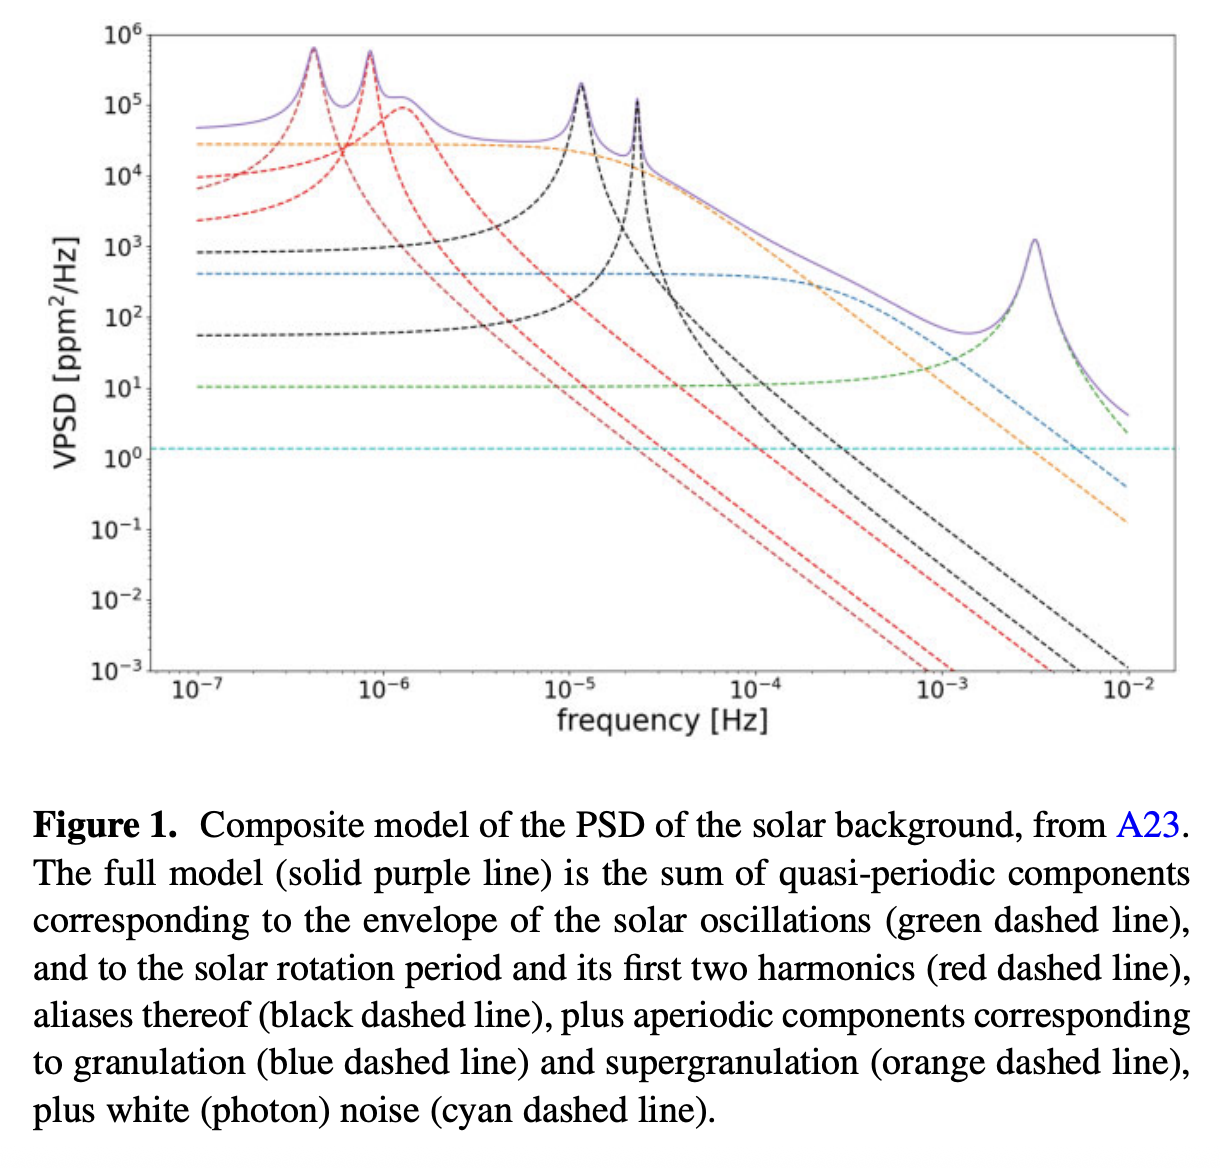

# Part 3: Gaussian Process 

## What is it?

So finally, lets talk about Gaussian Processes and what they actually are.

The fundamental assumption of a Gaussian Process is that the joint probability distribution is well described by a multi-variate gaussian distribution.

Formally:
$$ p(\mathbf{y}) = \mathcal{N}(\mathbf{m},\mathbf{K}) $$
where $\mathbf{m}$ is the mean vector and $\mathbf{K}$ is the kernel function, or the covariance.

What you might notice is that if the kernel function $\mathbf{K}$ is that of independent data points (as in, there is no covariance), that this collapses to a typical least-squares regression problem. That means that **fundamentally, a least-squares regression is a special case of Gaussian Process Regression**

Of course, one other piece that we might want to put here is our new likelihood function for this kind of problem.

Recall that we said for independent data with Gaussian-distributed errors:   
$$ \mathcal{L}(\theta) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi \sigma_i^2}} \exp\left( -\frac{(y_i - f(x_i; \theta))^2}{2\sigma_i^2} \right) $$

Well this can be generalized into matrix form as (again, consult your favorite statistics textbook):

$$ \mathcal{L}(\theta,\phi) = \frac{1}{\sqrt{det(2\pi K)}}\exp(-\frac{1}{2}(y-m)^T K^{-1} (y-m)) $$

This likelihood function is fully capable of handling one of those handy kernel functions that we looked at earlier.

## A few subtle points and practical tips

- A GP is **not a method for fitting a function to data**. It fits the parameters of the covariance that best describe the data. If your kernel function is well defined, you will be able to make a physical interpretation out of the kernel parameters. If your data is best fit by a function (e.g. an exoplanet transit), you should just fit that function normally. You could even implement that function as your mean function.

- GPs fit in the **time domain** rather than in the **fourier domain**. That eliminates the issues that often arise in Fourier space from gaps in the data (spectral windows, aliasing, etc).

- You should probably have at least some reasoning as to why you choose the kernel function that you pick for your GP. In astronomy luckily there are a few obvious options (more on this later).

- Your uncertainty estimation on your points really matters here! If you have outlier points with small uncertainties, you really need to remove them or they will totally skew your fit (I have an example of this that isn't in this tutorial if you ask me).


# Part 4: Practical Examples

## My favorite kernel

The SHO kernel models a stochastically-driven damped harmonic oscillator (see Foreman-Mackey (2017), link at the top of the notebook). In the time domain the covariance function is:

$$ k_{\mathrm{SHO}}(\tau) = S_0 \, \omega_0 \, Q \, e^{-\frac{\omega_0 \tau}{2Q}}
\cos\!\left(\eta \, \omega_0 \tau\right) ,$$

where

- $\tau = |t - t'|$ is the time lag,  
- $\omega_0$ is the undamped angular frequency of the oscillator,  
- $Q$ is the quality factor (how coherent the signal is/related to the damping),  
  - $Q \gg 1$: long-lived oscillations (narrow resonance in the power spectrum).  
  - $Q \sim 1$: strongly damped oscillations (broader peak).  
  - $Q < 1/2$: overdamped, no oscillatory behaviour.
- $S_0$ sets the power spectral density at $\omega_0$,  
- $\eta = \sqrt{1 - (4Q^2)^{-1}}$ ensures proper normalisation.


Stellar oscillations can be well described by damped harmonic oscillators.  
Granulation noise has a red-noise power spectrum that can be approximated by
a sum of SHO terms with different $Q$ and $\omega_0$.  
Quasi-periodic stellar variability (e.g. rotational modulation from spots) can be
captured with a mixture of SHO kernels.

In [ ]:
## lets visualize a sample of this covariance matrix

# Example: single SHO term
Q = 2.0        # quality factor
w0 = 2*np.pi/5 # frequency corresponding to 5 day period
S0 = 1.0       # amplitude scaling

kernel = terms.SHOTerm(S0=S0, w0=w0, Q=Q)

# build GP
gp = GaussianProcess(kernel)

# simulate
t = np.linspace(0, 50, 500)
gp.compute(t)
y = gp.sample()

# plot
plt.plot(t, y, marker='.', label="GP sample (SHO kernel)")
plt.xlabel("time")
plt.ylabel("flux")
plt.legend()
plt.show()

## Example 1: Stochastic low frequency variable – 1 term SHO kernel, mean = 0

For this example, we're going to look at something called a Stochastic Low Frequency Variable star observed by the TESS space mission. This target is studied in [M. G. Pedersen (2025)](https://ui.adsabs.harvard.edu/abs/2025MNRAS.539.2742P/abstract) (see their figure 3).

In [ ]:
### this cell grabs the light curve from MAST ###
# lc_search = lk.search_lightcurve('Gaia EDR3 2059070135632404992')

# lc = lc_search[0].download_all().stitch().remove_nans().remove_outliers(sigma=3)

# lightcurve = np.concatenate(([lc.time.value],[lc.flux.value],
#                              [lc.flux_err.value]))
# lightcurve_frame = pd.DataFrame(lightcurve.transpose(),columns=['time','flux','fluxerr'])
# lightcurve_frame.to_csv(tutorial_dir+'slf_lc.csv',index=False)

# flux_data = (lc.flux.value-1)*1e6
# time_data = lc.time.value-np.min(lc.time.value)
# yerr = np.asarray(lc.flux_err.value*1e6)

In [ ]:
### this cell avoids querying MAST ###
lc = pd.read_csv(tutorial_dir+'slf_lc.csv')
flux_data = (lc.flux-1)*1e6 # unit conversions
time_data = lc.time-np.min(lc.time)
yerr = np.asarray(lc.fluxerr*1e6) # unit conversions

In [ ]:
plt.figure(figsize=(15,4))
plt.scatter(time_data,flux_data,s=1)
plt.errorbar(time_data,flux_data,yerr=yerr,
             marker='None',linestyle='None',ecolor='grey',linewidth=0.5,zorder=0)
plt.xlabel('time days')
plt.ylabel('flux (ppm)')
plt.show()

plt.figure(figsize=(15,4))
plt.scatter(time_data,flux_data,s=1)
plt.errorbar(time_data,flux_data,yerr=yerr,
             marker='None',linestyle='None',ecolor='grey',linewidth=0.5,zorder=0)
plt.xlabel('time days')
plt.ylabel('flux (ppm)')
plt.xlim(5,10)
plt.show()

In [ ]:
freq_data,amp_data = psd.calc_lomb_scargle(time_data,flux_data,return_type='cd')
window_freq,window_power,Tobs = psd.spectral_window(time_data,return_type='cd')

psd_data = amp_data**2*Tobs
plt.plot(freq_data,psd_data)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('freq (c/d)')
plt.ylabel('PSD (ppm^2/(c/d))')
plt.show()

In [ ]:
# Non-periodic component
term = terms.SHOTerm(S0=1e5, w0=1.0, Q=0.5)
kernel = term

# Setup the GP
gp = celerite2.GaussianProcess(kernel, mean=0.0)
gp.compute(time_data, yerr=yerr)

print("Initial log likelihood: {0}".format(gp.log_likelihood(flux_data)))

In [ ]:
# create a frequency and omega array to plot the GP model with 
freq = np.logspace(np.log10(np.min(freq_data)), np.log10(np.max(freq_data)), 2000)
omega = 2 * np.pi * freq

In [ ]:
# function that defines a gp kernel with some hyperparameters
def set_params(params, gp):
    gp.mean = params[0]
    theta = np.exp(params[1:])
    gp.kernel = terms.SHOTerm(S0=theta[0], w0=theta[1], Q=theta[2])
    gp.compute(time_data, diag=yerr**2 + theta[3], quiet=True)
    return gp

# defines the negative log likelihood for the gp fit
def neg_log_like(params, gp):
    gp = set_params(params, gp)
    return -gp.log_likelihood(flux_data)

In [ ]:
# some guess of parameters
initial_params = [0.0, np.log(1e6), np.log(1.0), np.log(0.5), np.log(0.001)]

# a simple scipy minimizer
soln = minimize(neg_log_like, initial_params, method="L-BFGS-B", args=(gp,))
opt_gp = set_params(soln.x, gp)
soln

In [ ]:
# plot the results
plt.figure()
plt.title("GP fit - simple minimization")

plt.loglog(freq,opt_gp.kernel.get_psd(omega)*11.574,label='GP fit') # 11.574 is a unit conversion

plt.loglog(freq_data,psd_data,color='grey',alpha=0.5,label='data')
plt.loglog(freq_data,boxsmooth(psd_data),color='k',alpha=0.5,label='data smoothed')

# calculate the white noise term
var = np.mean(yerr**2) + np.exp(soln.x[-1])
wn = 0.25 * var * Tobs / len(time_data) * 11.574
plt.axhline(wn,color='k',linestyle='--',label='white noise')
plt.legend()
plt.xlabel('freq (c/d)')
plt.ylabel('psd (fraction^2/(c/d))')
plt.show()

And that's all you need to do! You've done your first Gaussian Process Regression. Now typically, people want to properly sample the posterior distribution, so here is some code that does that using emcee, but you can translate this to whatever your favorite sampler is.

In [ ]:
prior_mu = soln.x          # your initial guess vector
prior_sigma = [1.5,1.5,1.5,1.5,0.5]  # or you can make this an array if you want different widths per param
### Courtney's note: Loosening this prior gives you some extra solutions in the posterior, 
### which we probably don't want here

def log_prior(params):
    return -0.5 * np.sum(((params - prior_mu) / prior_sigma) ** 2)

# define the bayesian probability
def log_prob_1term(params, gp):
    gp = set_params(params, gp)
    lp = log_prior(params)
    if not np.isfinite(lp):
        dummy = np.zeros(N)  # dummy blobs
        return -np.inf, dummy, -np.inf
    ll = gp.log_likelihood(flux_data)
    if not np.isfinite(ll):
        dummy = np.zeros(N)
        return -np.inf, dummy, -np.inf
    return (
        ll + lp,
        gp.kernel.get_psd(omega),
        ll
    )

In [ ]:
coords = soln.x + 1e-5 * np.random.randn(32, len(soln.x))
N = len(omega)
dtype = [
    ("full_psd", float, N),
    ("log_likelihood", float)] # for blobs
# Set up backend in case you're limited on RAM
# backend = emcee.backends.HDFBackend(tutorial_dir+'chain.h5')
# backend.reset(coords.shape[0], coords.shape[1])
sampler = emcee.EnsembleSampler(
    coords.shape[0], coords.shape[1], log_prob_1term, args=(gp,), blobs_dtype=dtype#, backend=backend
)

In [ ]:
## this cell runs the MCMC but it's fast (< 1 min)

# burn in chain
state = sampler.run_mcmc(coords, 1000, progress=True)

# production chain
sampler.reset()
state = sampler.run_mcmc(state, 2000, progress=True)

chain = sampler.get_chain(discard=100, flat=True)

with open(tutorial_dir+'slf_chain.pkl', 'wb') as f:
    pickle.dump(chain, f)

# google emcee blobs if you want to know what this is doing
blobs = sampler.get_blobs(discard=1000, thin=50, flat=True)  # shape: (nsteps, nwalkers)

# THIS WILL BE LARGE IN MEMORY IF YOU AREN'T CAREFUL
# SOMETIMES EVEN IF YOU ARE CAREFUL IT'S STILL LARGE
with open(tutorial_dir+'slf_blobs.pkl', 'wb') as f:
    pickle.dump(blobs, f)

In [ ]:
## this cell avoids the MCMC
# with open('slf_chain.pkl', 'rb') as f:
#     chain = pickle.load(f)
# with open('slf_blobs.pkl', 'rb') as f:
#     blobs = pickle.load(f)

In [ ]:
WN = np.percentile(chain[:,-1], [16, 50, 84], axis=0)

In [ ]:
# Access the full_psd for all samples
full_psd = blobs["full_psd"]        # shape: (nsteps, nwalkers, N)
log_likelihoods = blobs["log_likelihood"]
max_ll = np.max(log_likelihoods)

In [ ]:
# this cell can sometimes take a bit of time
q = np.percentile(full_psd, [16, 50, 84], axis=0)

In [ ]:
plt.plot(freq, q[1]*11.574, color="blue", label='best fit model')
plt.fill_between(freq, q[0]*11.574, q[2]*11.574, color="blue", alpha=0.3)

correct_psd = q[1]*11.574

# calculate white noise
var = np.mean(yerr**2) + np.exp(WN[1])
wn = 0.25 * var * Tobs / len(time_data) * 11.574

plt.plot(freq,(correct_psd + wn),color='red', label='model + WN') 


plt.plot(freq_data,psd_data,color='grey',alpha=0.5,label='data')
plt.plot(freq_data,boxsmooth(psd_data),color='k',linewidth=1,zorder=0)

plt.legend()
plt.xlim(freq.min(), freq.max())
plt.xlabel("frequency [1 / day]")
plt.ylabel("PSD [day ppm$^2$]")
plt.xscale('log')
plt.yscale('log')

_ = plt.title("posterior psd using celerite2 + emcee")

In [ ]:
plot = corner.corner(chain,
                    labels=['mean','lnS0','lnw0','lnQ','lnWN'],
                    quantiles=[0.50],show_titles=True,title_quantiles=[0.16,0.5,0.84])

In [ ]:
## lets draw a sample from the posterior
dummy_t = np.linspace(np.min(time_data),np.max(time_data),2000)
for sample in chain[np.random.randint(len(chain), size=1)]:
    gp = set_params(sample, gp)
    conditional = gp.condition(flux_data, dummy_t)
    dummy_y = conditional.sample()

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(dummy_t, dummy_y, color="tab:red")
plt.scatter(time_data,flux_data,s=1,color='k')
plt.errorbar(time_data,flux_data,yerr=yerr,
             marker='None',linestyle='None',ecolor='grey',linewidth=0.5,zorder=0)
plt.xlabel('time days')
plt.ylabel('flux (fraction)')
plt.show()

plt.figure(figsize=(15,4))
plt.plot(dummy_t, dummy_y, color="tab:red")
plt.scatter(time_data,flux_data,s=1,color='k')
plt.errorbar(time_data,flux_data,yerr=yerr,
             marker='None',linestyle='None',ecolor='grey',linewidth=0.5,zorder=0)
plt.xlabel('time days')
plt.ylabel('flux (fraction)')
plt.xlim(5,10)
plt.show()

## Example 2: Solar-like oscillator – 2 term SHO kernel, mean = 0

For this example, we're going to look at an oscillating red giant observed by the Kepler space telescope. This particular target comes from [C. Crawford (2024a)](https://ui.adsabs.harvard.edu/abs/2024MNRAS.528.7397C/abstract).

In [ ]:
rgb_lc = pd.read_csv(tutorial_dir+'KIC8525150_LC.csv')
rgb_lc

In [ ]:
time_data = np.asarray(rgb_lc['time'])
flux_data = (np.asarray(rgb_lc['flux']))*1e6 # convert to ppm
mu = np.nanmedian(rgb_lc['flux'])
yerr = np.abs((1e-10/mu))*1e6 # unit conversion

In [ ]:
plt.figure(figsize=(15,4))
plt.scatter(time_data,flux_data,s=1)
plt.errorbar(time_data,flux_data,yerr=yerr,
             marker='None',linestyle='None',ecolor='grey',linewidth=0.5,zorder=0)
plt.xlabel('time days')
plt.ylabel('flux (ppm)')
plt.show()

plt.figure(figsize=(15,4))
plt.scatter(time_data,flux_data,s=1)
plt.errorbar(time_data,flux_data,yerr=yerr,
             marker='None',linestyle='None',ecolor='grey',linewidth=0.5,zorder=0)
plt.xlabel('time days')
plt.ylabel('flux (ppm)')
plt.xlim(145,155)
plt.show()

In [ ]:
freq_data,amp_data = psd.calc_lomb_scargle(time_data,flux_data,return_type='cd')
window_freq,window_power,Tobs = psd.spectral_window(time_data,return_type='cd')


psd_data = amp_data**2*Tobs
plt.plot(freq_data,psd_data)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('freq (muhz)')
plt.ylabel('PSD (ppm^2/muhz')
plt.show()

In [ ]:
# Periodic component
term1 = terms.SHOTerm(S0=1e3, w0=100, Q=4)

# Non-periodic component
term2 = terms.SHOTerm(S0=1e4, w0=1.0, Q=0.5)
kernel = term2 

# Setup the GP
gp = celerite2.GaussianProcess(kernel, mean=0.0)
gp.compute(time_data, yerr=yerr)

print("Initial log likelihood: {0}".format(gp.log_likelihood(flux_data)))

In [ ]:
freq = np.logspace(np.log10(np.min(freq_data)), np.log10(np.max(freq_data)), 1000)
omega = 2 * np.pi * freq

In [ ]:
def set_params(params, gp):
    gp.mean = params[0]
    theta = np.exp(params[1:])
    gp.kernel = (terms.SHOTerm(S0=theta[0], w0=theta[1], Q=theta[2])+
                 terms.SHOTerm(S0=theta[3], w0=theta[4], Q=theta[5]))
    gp.compute(time_data, diag=yerr**2 + theta[6], quiet=True)
    return gp


def neg_log_like(params, gp):
    gp = set_params(params, gp)
    return -gp.log_likelihood(flux_data)

In [ ]:
initial_params = [0.0, 
                  np.log(1e3), np.log(100), np.log(4), 
                  np.log(1e4), np.log(1.0), np.log(0.5), 
                  np.log(0.001)]


soln = minimize(neg_log_like, initial_params, method="L-BFGS-B", args=(gp,))
opt_gp = set_params(soln.x, gp)
soln

In [ ]:
plt.figure()
plt.title("maximum likelihood psd")

plt.loglog(freq,opt_gp.kernel.get_psd(omega)*11.574)
plt.loglog(freq_data,psd_data,color='grey',alpha=0.5)
plt.loglog(freq_data,boxsmooth(psd_data),color='k',alpha=0.5)

var = np.mean(yerr**2) + np.exp(soln.x[-1])
wn = 0.25 * var * Tobs / len(time_data) * 11.574
plt.axhline(wn) 

plt.xlabel('freq (c/d)')
plt.ylabel('psd (fraction^2/(c/d))')
plt.show()

In [ ]:
prior_mu = soln.x          # your initial guess vector
prior_sigma = 2.0          # or you can make this an array if you want different widths per param

def log_prior(params):
    return -0.5 * np.sum(((params - prior_mu) / prior_sigma) ** 2)

def log_prob_2term(params, gp):
    gp = set_params(params, gp)
    lp = log_prior(params)
    if not np.isfinite(lp):
        dummy = np.zeros(N)  # dummy blobs
        return -np.inf, dummy, dummy, dummy, -np.inf
    ll = gp.log_likelihood(flux_data)
    if not np.isfinite(ll):
        dummy = np.zeros(N)
        return -np.inf, dummy, dummy, dummy, -np.inf
    return (
        ll + lp,
        gp.kernel.get_psd(omega),
        gp.kernel.terms[0].get_psd(omega),
        gp.kernel.terms[1].get_psd(omega),
        ll
    )

In [ ]:
coords = soln.x + 1e-5 * np.random.randn(32, len(soln.x))
N = len(omega)
dtype = [
    ("full_psd", float, N),
    ("term1_psd", float, N),
    ("term2_psd", float, N),
    ("log_likelihood", float)] # for blobs
# Set up backend to reduce load on RAM space
# backend = emcee.backends.HDFBackend('chain.h5')
# backend.reset(coords.shape[0], coords.shape[1])
sampler = emcee.EnsembleSampler(
    coords.shape[0], coords.shape[1], log_prob_2term, args=(gp,), blobs_dtype=dtype#, backend=backend
)

In [ ]:
## this cell actually runs the MCMC and will take about 5 minutes to run

# # burn in chain
# state = sampler.run_mcmc(coords, 1000, progress=True)

# # production chain
# sampler.reset()
# state = sampler.run_mcmc(state, 2000, progress=True)

# chain = sampler.get_chain(discard=100, flat=True)

# with open(tutorial_dir+'rgb_chain.pkl', 'wb') as f:
#     pickle.dump(chain, f)

# blobs = sampler.get_blobs(discard=1000, thin=50, flat=True)  # shape: (nsteps, nwalkers)
# # THIS WILL BE LARGE IN MEMORY IF YOU AREN'T CAREFUL
# # SOMETIMES EVEN IF YOU ARE CAREFUL IT'S STILL LARGE
# with open(tutorial_dir+'rgb_blobs.pkl', 'wb') as f:
#     pickle.dump(blobs, f)

In [ ]:
## this cell bypasses running the sampler
with open('rgb_chain.pkl', 'rb') as f:
    chain = pickle.load(f)
with open('rgb_blobs.pkl', 'rb') as f:
    blobs = pickle.load(f)

In [ ]:
WN = np.percentile(chain[:,-1], [16, 50, 84], axis=0)

In [ ]:
# Access the full_psd for all samples
full_psd = blobs["full_psd"]        # shape: (nsteps, nwalkers, N)
term1_psd = blobs["term1_psd"]      # shape: (nsteps, nwalkers, N)
term2_psd = blobs["term2_psd"]      # shape: (nsteps, nwalkers, N)
log_likelihoods = blobs["log_likelihood"]
max_ll = np.max(log_likelihoods)

In [ ]:
# depending on the size of your blobs this cell might take some time
q = np.percentile(full_psd, [16, 50, 84], axis=0)
term1 = np.percentile(term1_psd, [16, 50, 84], axis=0)
term2 = np.percentile(term2_psd, [16, 50, 84], axis=0)

In [ ]:
plt.plot(freq, q[1]*11.574, color="blue",label='GP best fit')
plt.fill_between(freq, q[0]*11.574, q[2]*11.574, color="blue", alpha=0.3)

correct_psd = q[1]*11.574

var = np.mean(yerr**2) + np.exp(WN[1])
wn = 0.25 * var * Tobs / len(time_data) * 11.574

plt.plot(freq,(correct_psd + wn),color='red',label='model + WN') 

plt.plot(freq_data,psd_data,color='grey',alpha=0.5,label='data')
plt.plot(freq_data,boxsmooth(psd_data),color='k',linewidth=1,zorder=0)

plt.legend()
plt.xlim(freq.min(), freq.max())
plt.xlabel("frequency [1 / day]")
plt.ylabel("PSD [day fraction$^2$]")
plt.xscale('log')
plt.yscale('log')

_ = plt.title("posterior psd using celerite2 + emcee")

In [ ]:
plot = corner.corner(chain,
                    labels=['mean','lnS01','lnw01','lnQ1','lns02','lnw02','lnQ2','lnWN'],
                    quantiles=[0.50],show_titles=True,title_quantiles=[0.16,0.5,0.84])

In [ ]:
## lets draw a sample from the posterior
# do NOT be tempted to make dummy_t too big! You'll crash your RAM!!!
# this operation scales dangerously with number of points to sample on
dummy_t = np.linspace(245,255,1000)
for sample in chain[np.random.randint(len(chain), size=1)]:
    gp = set_params(sample, gp)
    conditional = gp.condition(flux_data, dummy_t)
    dummy_y = conditional.sample()

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(dummy_t, dummy_y, color="tab:red")
plt.scatter(time_data,flux_data,s=1,color='k')
plt.errorbar(time_data,flux_data,yerr=yerr,
             marker='None',linestyle='None',ecolor='grey',linewidth=0.5,zorder=0)
plt.xlabel('time days')
plt.ylabel('flux (fraction)')
plt.show()

plt.figure(figsize=(15,4))
plt.plot(dummy_t, dummy_y, color="tab:red")
plt.scatter(time_data,flux_data,s=1,color='k')
plt.errorbar(time_data,flux_data,yerr=yerr,
             marker='None',linestyle='None',ecolor='grey',linewidth=0.5,zorder=0)
plt.xlabel('time days')
plt.ylabel('flux (fraction)')
plt.xlim(245,255)
plt.show()

## Example 3: Transiting Exoplanet – some SHO terms, mean != 0

To preserve time, I'll point to some literature here rather than running a whole new model (I don't even work on exoplanets).

An example of using GPR to simultaneously fit an oscillating star with an exoplanet transit can be found in [S. Grunblatt (2017)](https://ui.adsabs.harvard.edu/abs/2017AJ....154..254G/abstract).

Below is the light curves that they used for this process. Now, instead of assuming a zero mean, as we've done in the last two examples, they used a transit model as the mean function, to fit simultaneously with the gaussian process that describes the star's activity

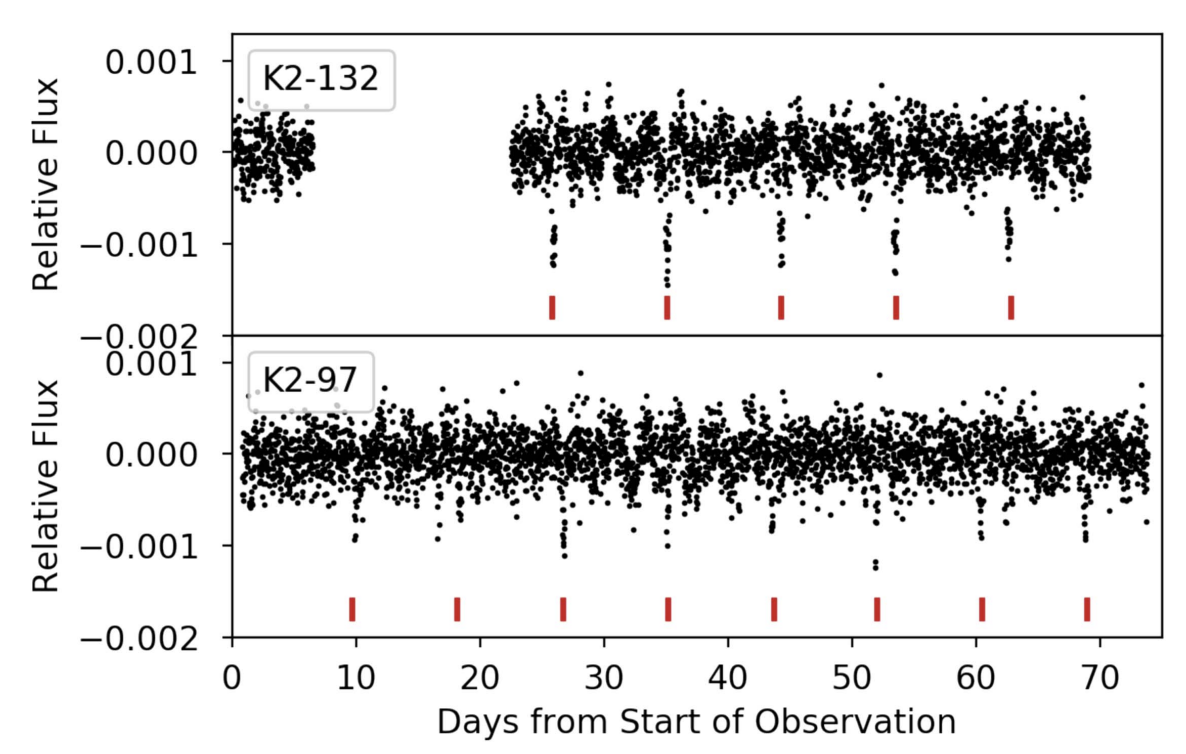

This figure shows the fit in time domain zoomed in on one transit

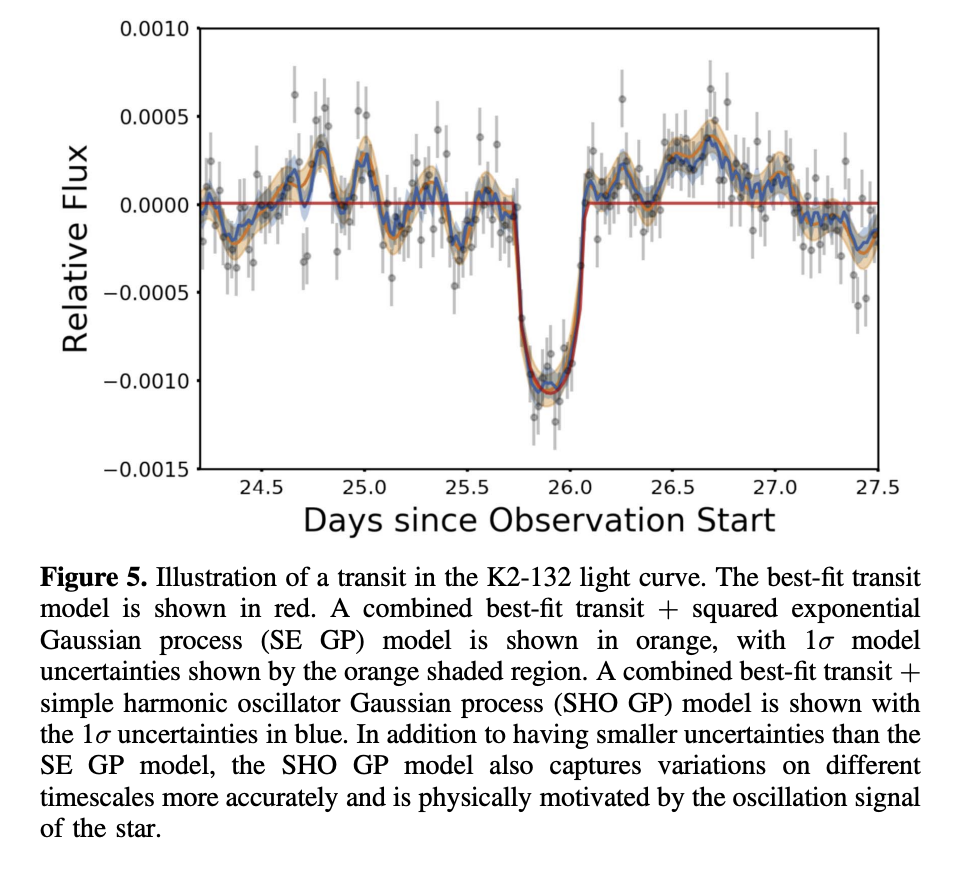

This figure shows the power spectrum density of the star, showcasing its oscillations and granulation background

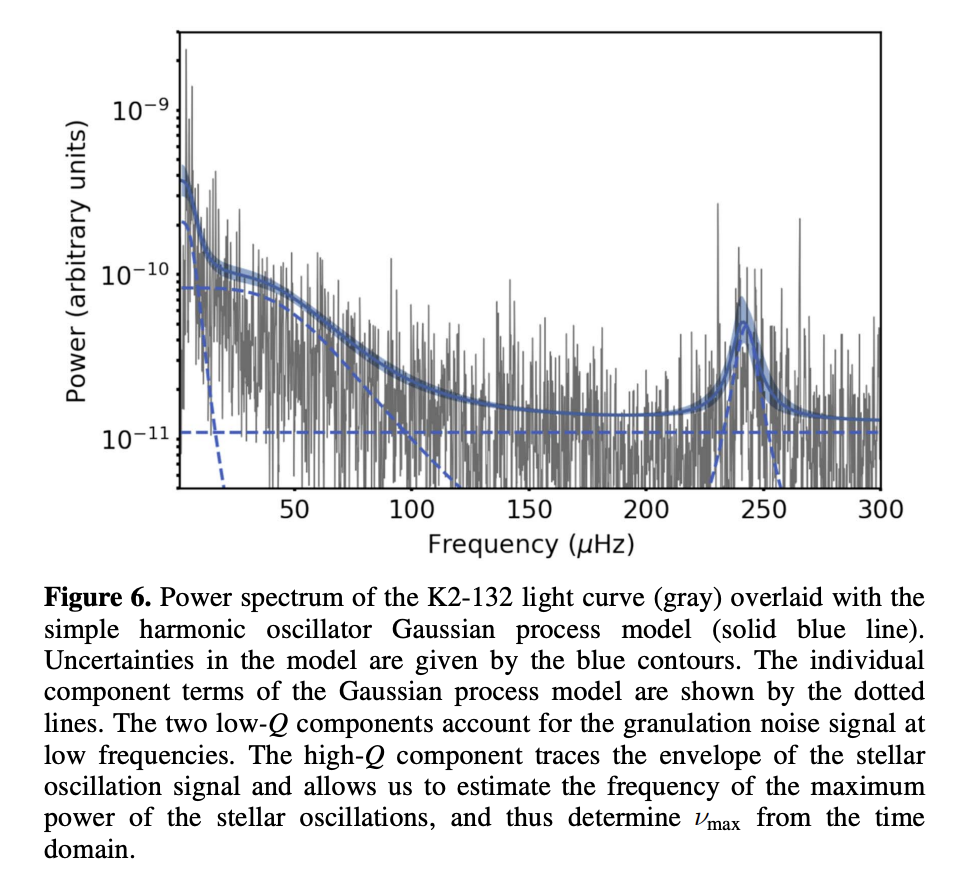

## Example 4: GPR's performance when the data has gaps

These examples come from [O'Sullivan and Aigrain 2024](https://ui.adsabs.harvard.edu/abs/2024MNRAS.531.4181O/abstract). The test I'll show here is discussed in their section 5.1, and is worth reading fully to understand it.

These plots show the two test light curves. Left has even sampling with no gaps, whereas the right is the sample underlying model with observation times pulled from real HARPS data.

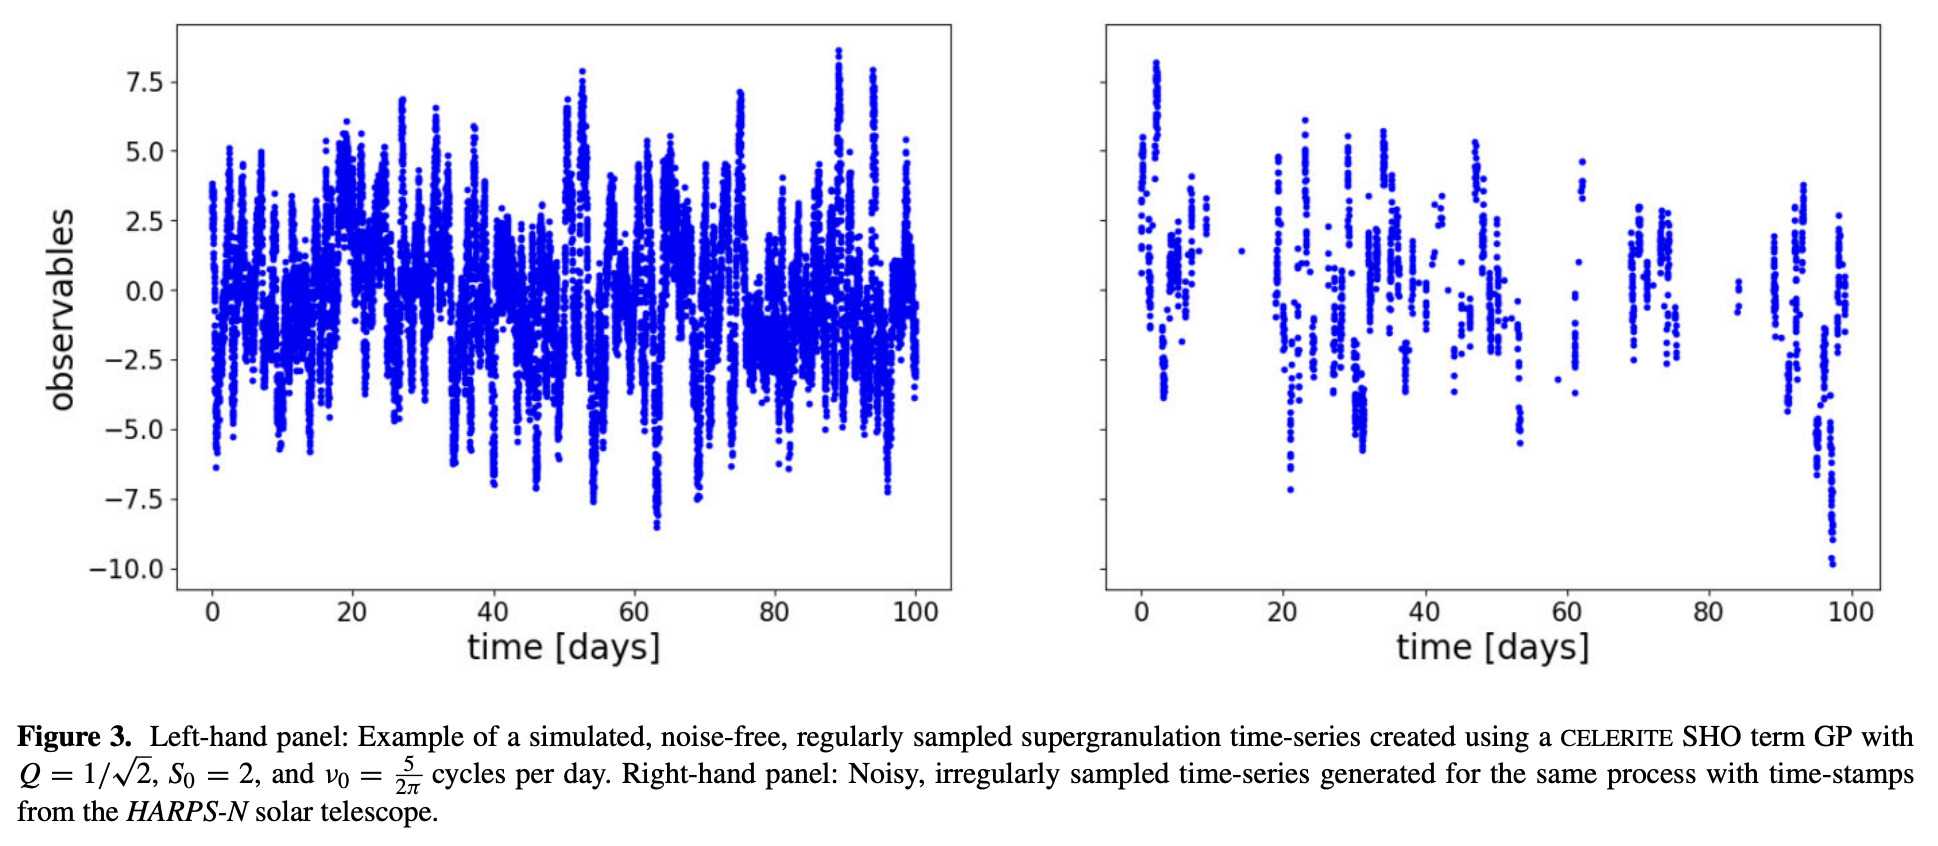

This figure shows the resulting PSD fits using Fourier Analysis (green) and using GPR (pink) with the true underlying distribution in blue. Here, it is clear that in the gappy case, GPR is much better at reproducing the true underlying distribution used to generate the data.

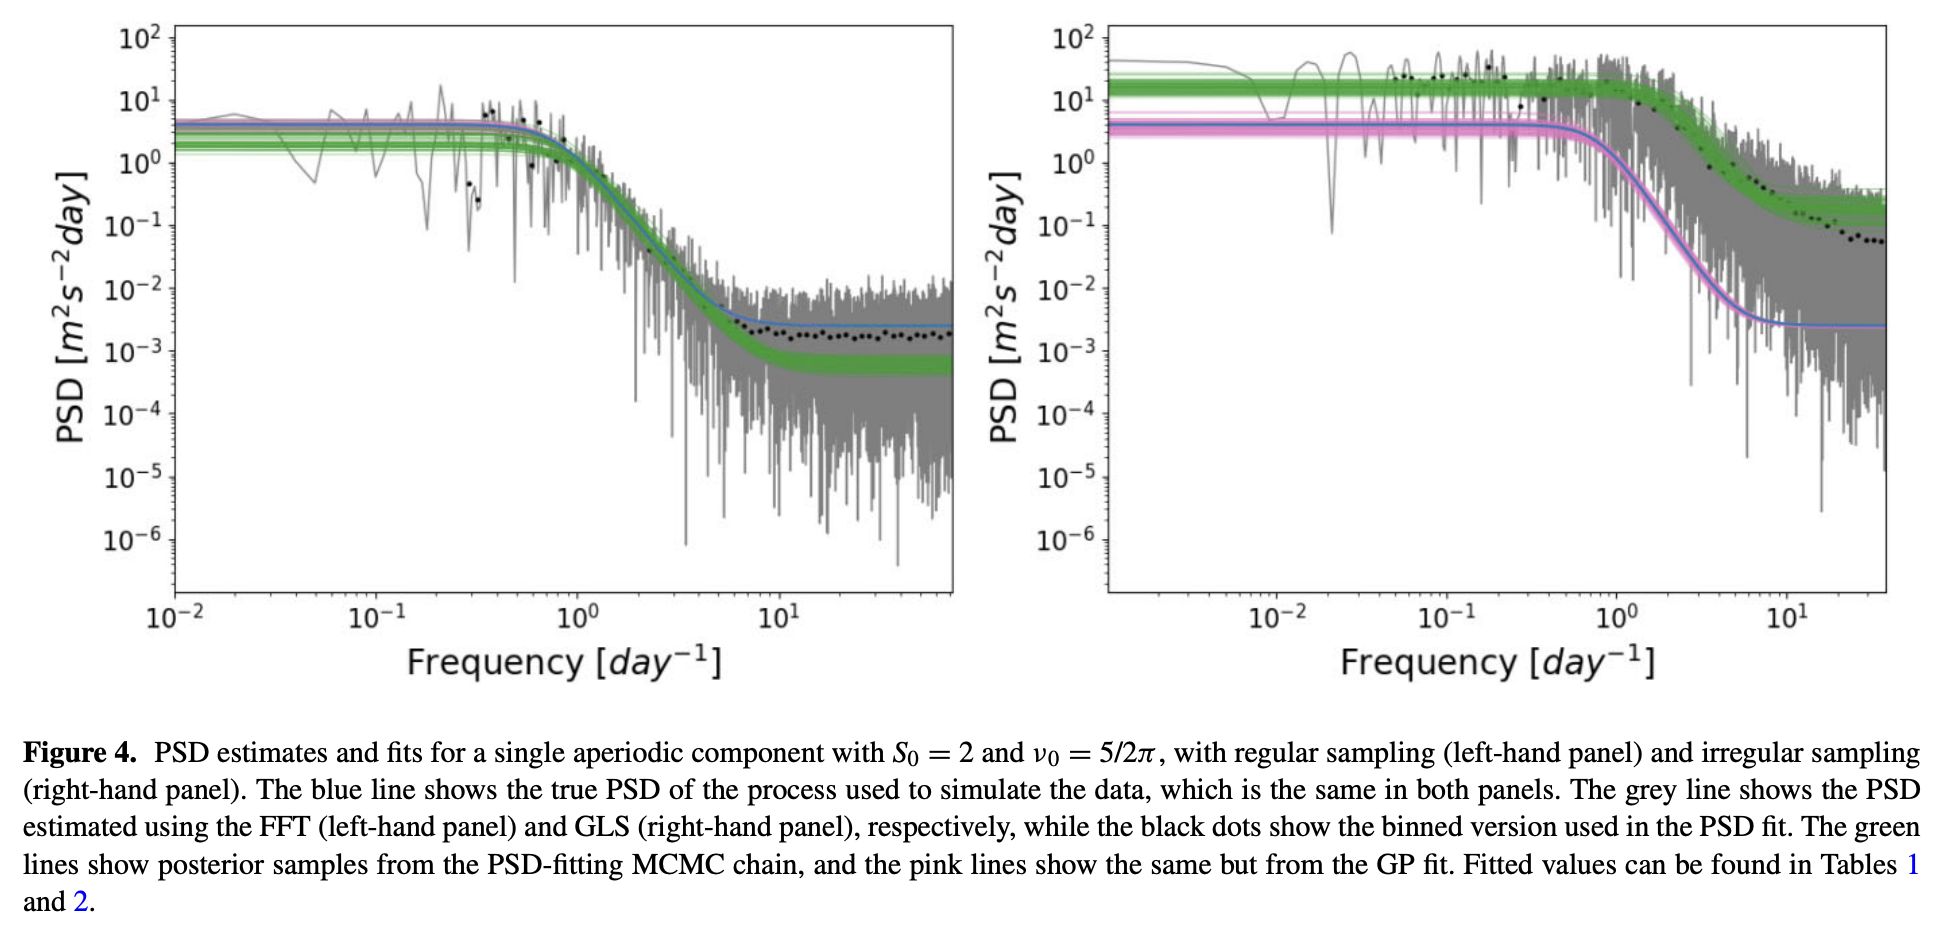